<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_random_initial_weights_decorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_validation_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cancer_random_initial_weights_decorrelation

> Purpose of this notebook is to implement our ensemble decorrelation idea

In [1]:
#| default_exp cancer_random_initial_weights_decorrelation

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [2]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

## Load the data

In [5]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
#bs=256
#bs=698
bs=256
bs_tune=256
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

test_eq(x.shape,xtune.shape)

# if on_colab:
#     os.chdir('cancer-proj')

## Load aug pipelines here

In [6]:
#| hide

aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

In [7]:
#| hide
#show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

In [8]:
#| hide

#show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [9]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

## New API for ensemble decorrelation:

In [10]:
#| export

class P4BarlowTwinsModel(Module):

    def __init__(self,model,encoder2,projector2):
        self.model = model #frozen model
        self.encoder2 = encoder2
        self.projector2 = projector2

        #put on GPU
        if torch.cuda.is_available(): self.to(torch.device('cuda'))


        
    def forward(self,x,y):
        
        return self.model(x),self.projector2(self.encoder2(x))

def create_p4barlow_twins_model(model,encoder2, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder2)
    with torch.no_grad(): 
        model.cpu()
        encoder2.cpu()
        
        representation = encoder2(torch.randn((2,n_in,128,128)))

    model.cpu()
    encoder2.cpu()

    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)

    return P4BarlowTwinsModel(model=model,encoder2=encoder2,projector2=projector2)


class BarlowTwinsEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in,t=0.1,s=0.1,lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.t=t
        self.s=s
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector2[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:
            
            assert False

            #Two distorted views according to first augmentation distribution
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug1(TensorImageBW(self.x))
          
            #Two distorted views according to second augmentation distribution
            #xi_2,xj_2 = self.aug2(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))


        elif self.n_in == 3:
            
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
            
        
        self.learn.xb = (torch.cat([xi, xj]),torch.cat([xi, xj]))


    def before_epoch(self):
        
        ##########"Best" annealing schedule found so far
        if self.epoch < 5:
            self.t=0.5
            self.s=0.5
            
        if self.epoch == 10:
            self.t=0.25
            self.s=0.25
            
        if self.epoch == 15:
            self.t=0.125
            self.s=0.125
            
        if self.epoch == 20:
            self.t=0.05
            self.s=0.05
            
        if self.epoch == 25:
            self.t=0.025
            self.s=0.025
        ##########


    @torch.no_grad()
    def show(self, n=1):
        
        x=self.learn.x[0]
        y=self.learn.x[1]
        
        bs = x.size(0)//2
        x1,x2  = x[:bs], x[bs:]
        y1,y2  = y[:bs], y[bs:]
        
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug1.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        
        y1 = self.aug1.decode(y1[idxs].to('cpu').clone()).clamp(0,1)
        y2 = self.aug1.decode(y2[idxs].to('cpu').clone()).clamp(0,1)
        
        images = []
        for i in range(n): images += [x1[i],x2[i],y1[i],y2[i]]
        show_batch(x1[0], None, images, max_n=len(images), nrows=n)

        return
    
def show_btens_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwinsEns(aug,n_in=n_in,print_augs=print_augs)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins_ens.show(n=n)


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


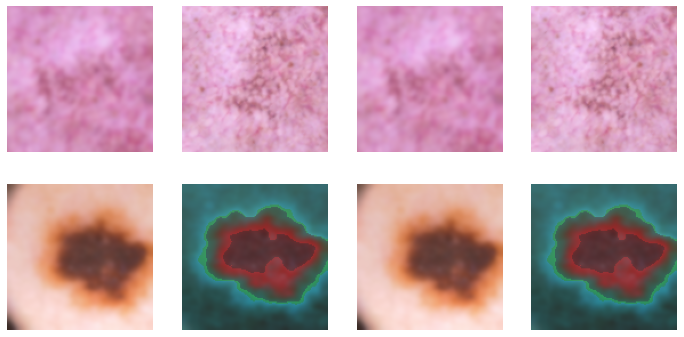

In [11]:
#| hide
show_btens_batch(dls_train,3,aug_pipelines,n=2)

Next thing, is need to patch in the new loss function!

In [12]:
#| export

class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def lf_rbt_ens(pred,I,lmb,
               t,
               s,
               ):

    
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients
    
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)
    
    #Make sure gradients are turned off / turned on appropriately
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)

    #Within frozen model 
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    
    #Within model_2 (unfrozen)
    C2 = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C2 - I)**2


    #Between model term 2
    C = (z1norm * z1norm_2) 
    cdiff_3 = (1/bs)*(C)**2
    
    C = (z2norm * z2norm_2) 
    cdiff_4 = (1/bs)*(C)**2
    
    cdiff_between = 0.5*cdiff_3 + 0.5*cdiff_4
    
    bt_loss = (cdiff_2*I).sum() + lmb*(cdiff_2*(1-I)).sum()

    print(bt_loss)
    print(cdiff_between/sum())
    
    torch.cuda.empty_cache()
    return bt_loss

In [13]:
#| hide
@patch
def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=self.t,s=self.s) #pass them to loss function


In [14]:
#| export

model,encoder = create_model('no_pretrain',device,ps=8192,n_in=3)

print('train this guy the usual way')

model.eval()
model = grad_on(model,on=False)

print('then turn off gradients etc')

train this guy the usual way
then turn off gradients etc


In [15]:
print(next(encoder.parameters()).device)


cuda:0


In [16]:
create_model??

In [17]:
#| hide

ps=8192
_,encoder2 = create_model('no_pretrain',device,ps=ps,n_in=3)

model2 = create_p4barlow_twins_model(model,encoder2,hidden_size=ps,projection_size=ps)

In [18]:
def create_ens_model(model,device,ps=8192,n_in=3):
    "Input a barlow twins model (encoder and projector) that has already been trained"

    #Put into eval mode and turn off gradient
    model.eval()
    model = grad_on(model,on=False)

    _,encoder2 = create_model('no_pretrain',device,ps=ps,n_in=3)
    model2 = create_p4barlow_twins_model(model,encoder2,hidden_size=ps,projection_size=ps)

    encoder2 = model2.encoder2
    if device == 'cuda':
        model2.cuda()
        encoder2.cuda()


    return model2,encoder2


No splitter needed at the moment since we are just using it on random initial weights.

In [19]:
#| hide

learn = Learner(dls_train,model2,cbs=[BarlowTwinsEns(aug_pipelines,n_in=3,lmb=1/8192,print_augs=False)])


In [20]:
#learn.fit(1)

## Step 1) Train several BT models (say for 100 epochs)

## Step 2) Train several BT models, decorrelating from models in 1 (pairwise)

## Step 3) Fine tune models in 1) and in 2)

## Compare pairwise performance in 1) and in 2)

## Note: using this default encoder, for random weights, doesn't seem to work real well.

## Note: we don't actually want to freeze the resnet when pretraining in this notebook, since the initial weights are random. So we just need to make sure encoder_fine_tune isn't doing that

## Test: make sure that it freezes the appropriate part of model:

Make sure resnet frozen, linear head unfrozen:

In [21]:
bt_model,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
model = LM(encoder)
test_eq(len(my_splitter(model)),2)
test_eq(len(my_splitter_bt(bt_model)),2)

learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
learn.freeze()
print('body should be frozen, (sans batchnorm) linear head unfrozen')
learn.summary()

Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

body should be frozen, (sans batchnorm) linear head unfrozen


LM (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                               

## We can use this to check the  bt-model is of the appropriate type: resnet + projector

In [22]:
#| hide

#test : manual. BT

learn = Learner(dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(aug_pipelines,n_in=3,lmb=1/8192,print_augs=False)])
learn.freeze()
print('body should be frozen, (sans batchnorm) projector unfrozen')
learn.summary()

body should be frozen, (sans batchnorm) projector unfrozen


BarlowTwinsModel (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                 

## Ok, so `fit_one_cycle` works the best! So let's patch it back in. Also, just need to add `pretrain` argument to `fine_tune`

In [23]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above / earlier commit)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    #torch.save(model.state_dict(), self.tuned_model_path)
    return metrics #

@patch
def train_encoder(self:main_train):
    "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

    try: #get existing encoder and plonk on new projector
        encoder = self.encoder
        encoder.cpu()
        bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
        bt_model.cuda()

    except AttributeError: #otherwise, create
        bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    if self.pretrain: #train encoder according to fit policy

        #lmb=0.005 #this guy doesn't seem to work
        lmb=1/8192
        print(f'lmb={lmb}')
        learn = Learner(self.dls_train,bt_model,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
        main_train.fit(learn,fit_type='encoder_fine_tune',
                        epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                        initial_weights=self.initial_weights,
                        pretrain=self.pretrain
                        )
        
    self.encoder = bt_model.encoder
    self.bt_model=bt_model

# Comments: `train_encoder` has a few differences. `fine_tune` basically the same except a different encoder... 

In [24]:
class main_train_ensemble(main_train):

    def __init__(self,
                 dls_train, #used for training BT (if pretrain=True)
                 dls_tune , #used for tuning
                 dls_valid, #used to compute metrics / evaluate results. 
                 xval, #currently `predict_model` below assumes this is entire validation / test data
                 yval,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights, #Which initial weights to use
                 pretrain, #Whether to fit BT
                 num_epochs, #number of BT fit epochs
                 numfit, #number of tune_fit epochs
                 freeze_num_epochs, #How many epochs to freeze body for when training BT
                 freeze_numfit, #How many epochs to freeze body for when fine tuning
                 ps=8192, #projection size
                 n_in=3, #color channels
                 indim=2048, #dimension output of encoder (2048 for resnet50)
                 outdim=9, #number of classes
                 print_report=False, #F1 metrics etc
                 print_plot=False, #ROC curve
                 tune_model_path=None, #save models after fine tuning
                 model=None, #BT model that has already been trained; i.e. what we are pushing rep away from...
                 ):
        store_attr()
        self.vocab = self.dls_valid.vocab
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def train_encoder(self):
        "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"


        with torch.no_grad():
            bt_model2,encoder2 = create_ens_model(model=self.model,ps=self.ps,device=self.device)

        if self.pretrain: #train encoder according to fit policy

            #lmb=0.005 #this guy doesn't seem to work
            lmb=1/8192
            print(f'lmb={lmb}')
            learn = Learner(self.dls_train,bt_model2,cbs=[BarlowTwinsEns(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
            main_train_ensemble.fit(learn,fit_type='encoder_fine_tune',
                            epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                            initial_weights=self.initial_weights,
                            pretrain=self.pretrain
                            )
            
        self.encoder2 = bt_model2.encoder2
        self.bt_model2=bt_model2


    def fine_tune(self):
        "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)


        model = LM(self.encoder2)
        learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        #debugging
        #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        main_train_ensemble.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
        
        scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
        auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

        #torch.save(model.state_dict(), self.tuned_model_path)
        return metrics #


# Some tests:

Check that training the second encoder doesn't change the weights of the first encoder (i.e. that it is really frozen)

In [25]:
#| export

class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def lf_rbt_ens(pred,I,lmb,
               t,
               s,
               ):

    
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients
    
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)
    
    #Make sure gradients are turned off / turned on appropriately
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)

    #Within frozen model 
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    
    #Within model_2 (unfrozen)
    C2 = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C2 - I)**2


    #Between model term 2
    C = (z1norm * z1norm_2) 
    cdiff_3 = (1/bs)*(C)**2
    
    C = (z2norm * z2norm_2) 
    cdiff_4 = (1/bs)*(C)**2
    
    cdiff_between = 0.5*cdiff_3 + 0.5*cdiff_4
    
    bt_loss = (cdiff_2*I).sum() + lmb*(cdiff_2*(1-I)).sum()

    loss = bt_loss + t*cdiff_between.sum()

    print(f'bt loss: {bt_loss} ')
    print(f'Scaled between loss: {t*cdiff_between.sum()} ')
    
    torch.cuda.empty_cache()
    return loss

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()

16177

In [27]:
num_epochs=1
freeze_num_epochs=1
freeze_numfit=1
numfit=1

main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights='no_pretrain',pretrain=True,
        num_epochs=1,numfit=1,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,
                )
        
main.train_encoder()

print('trained first encoder')

s=0
for p in main.bt_model.parameters():
    s+=p.sum().item()
print(f'sum of first models parameters is: {s} ')


main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights='no_pretrain',pretrain=True,
        num_epochs=1,numfit=1,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,model=main.bt_model
                )

main_ens.train_encoder()

print('trained second encoder (decorrelated)')

s2=0
for p in main.bt_model.parameters():
    s2+=p.sum().item()
print(f'sum of first models parameters is: {s2} ')

test_eq(s,s2)

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6645.418457,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained first encoder
sum of first models parameters is: 37929.50347258191 
lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,26878.902344,None,00:07


bt loss: 7529.03466796875 
Scaled between loss: 18174.791015625 
bt loss: 6822.9716796875 
Scaled between loss: 21207.5546875 
trained second encoder (decorrelated)
sum of first models parameters is: 37929.50347258191 


In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

582

Test that fine tuning works (i.e. runs) and weights don't change when they shouldnt 

In [29]:
metrics1 = main.fine_tune()
s=0
for p in main.bt_model.parameters():
    s+=p.sum().item()
print(f'sum of first models parameters is: {s} ')

metrics2 = main_ens.fine_tune()

s2=0
for p in main.bt_model.parameters():
    s2+=p.sum().item()
print(f'sum of first models parameters is: {s} ')
test_eq(s,s2)


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.396944,None,00:06


epoch,train_loss,valid_loss,time
0,2.294426,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        20
                     nevus       0.00      0.00      0.00        20
pigmented benign keratosis       0.00      0.00      0.00        20
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.11      0.80      0.19        20
           vascular lesion       0.00      0.00      0.00        20

                  accuracy                           0.09       174
                 macro avg       0.01      0.09      0.02       174
              weighted avg       0.01      0.09      0.02       174

sum of first models parameters is: 38060.014380230044 
pretrain was True, and about to linear_fine_tune


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

epoch,train_loss,valid_loss,time
0,2.310013,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.439386,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.11      1.00      0.21        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        20
                     nevus       0.00      0.00      0.00        20
pigmented benign keratosis       0.00      0.00      0.00        20
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.00      0.00      0.00        20
           vascular lesion       0.00      0.00      0.00        20

                  accuracy                           0.11       174
                 macro avg       0.01      0.11      0.02       174
              weighted avg       0.01      0.11      0.02       174

sum of first models parameters is: 38060.014380230044 


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

# Initial experiment: Train several BT models (standard way) and several decorrelated nets. Compare ensemble performance within standard way, and between

In [38]:
@patch
def before_epoch(self:BarlowTwinsEns):
    
    ##########"Best" annealing schedule found so far
    print('patched in new annealing schedule')
    self.s='foo'
        
    if self.epoch <10:
        self.t=0.1

    if self.epoch == 20:
        self.t=0.01

    if self.epoch == 30:
        self.t=0.001

    if self.epoch == 40:
        self.t=0.0

    return

In [31]:

num_epochs=1
freeze_num_epochs=1
freeze_numfit=1
numfit=1


main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
    aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
    initial_weights='no_pretrain',pretrain=True,
    num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
    print_report=True,
            )

main.train_encoder()
print('trained first encoder')

main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights='no_pretrain',pretrain=True,
        num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,model=main.bt_model
                )

main_ens.train_encoder()

metrics = main.fine_tune()
print('fine tuned number 1')
metrics_ens = main_ens.fine_tune()
print('fine tuned number 2')

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6569.790527,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained first encoder
lmb=0.0001220703125
lr_max=0.0030199517495930195
patched in new annealing schedule


epoch,train_loss,valid_loss,time
0,8495.072266,None,00:07


bt loss: 7876.923828125 
Scaled between loss: 863.212158203125 
bt loss: 7375.45556640625 
Scaled between loss: 879.4693603515625 
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.423330,None,00:06


epoch,train_loss,valid_loss,time
0,2.480873,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.11      1.00      0.21        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        20
                     nevus       0.00      0.00      0.00        20
pigmented benign keratosis       0.00      0.00      0.00        20
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.00      0.00      0.00        20
           vascular lesion       0.00      0.00      0.00        20

                  accuracy                           0.11       174
                 macro avg       0.01      0.11      0.02       174
              weighted avg       0.01      0.11      0.02       174

fine tuned number 1
pretrain was True, and about to linear_fine_tune


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

epoch,train_loss,valid_loss,time
0,2.437115,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.417465,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        20
      basal cell carcinoma       0.11      1.00      0.21        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        20
                     nevus       0.00      0.00      0.00        20
pigmented benign keratosis       0.00      0.00      0.00        20
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.00      0.00      0.00        20
           vascular lesion       0.00      0.00      0.00        20

                  accuracy                           0.11       174
                 macro avg       0.01      0.11      0.02       174
              weighted avg       0.01      0.11      0.02       174

fine tuned number 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [40]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [41]:
num_epochs=50
freeze_num_epochs=1
freeze_numfit=6
numfit=75

main_dict_1 = {}
main_dict_2 = {}

for i in range(2):

    if i == 1:

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
            aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
            initial_weights='no_pretrain',pretrain=True,
            num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
            print_report=True,
                    )
        
        main.train_encoder()
        print('trained first encoder')

    main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
            aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
            initial_weights='no_pretrain',pretrain=True,
            num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
            print_report=True,model=main.bt_model
                    )
    
    main_ens.train_encoder()
    print('trained second encoder')

    metrics = main.fine_tune()
    print('fine tuned number 1')
    metrics_ens = main_ens.fine_tune()
    print('fine tuned number 2')

    main_dict_1[i] = metrics
    main_dict_2[i] = metrics_ens

    print('please see loss function: only have rr term')



lmb=0.0001220703125
lr_max=0.0030199517495930195
patched in new annealing schedule


epoch,train_loss,valid_loss,time
0,7497.475586,None,00:07
1,7261.932129,None,00:07
2,6834.811523,None,00:07
3,6407.141602,None,00:07
4,6125.150391,None,00:07
5,5863.493164,None,00:07
6,5714.076660,None,00:07
7,5530.636230,None,00:07
8,5431.887695,None,00:07
9,5237.257324,None,00:07


bt loss: 6550.9404296875 
Scaled between loss: 1390.3265380859375 
bt loss: 5142.33837890625 
Scaled between loss: 1920.2353515625 
patched in new annealing schedule
bt loss: 6818.78759765625 
Scaled between loss: 1476.4964599609375 
bt loss: 4489.8583984375 
Scaled between loss: 1311.4942626953125 
patched in new annealing schedule
bt loss: 4909.29638671875 
Scaled between loss: 1393.8944091796875 
bt loss: 4078.51806640625 
Scaled between loss: 1685.0364990234375 
patched in new annealing schedule
bt loss: 3963.10302734375 
Scaled between loss: 1102.897705078125 
bt loss: 4479.2265625 
Scaled between loss: 897.8204956054688 
patched in new annealing schedule
bt loss: 4335.26318359375 
Scaled between loss: 841.4434814453125 
bt loss: 4190.5791015625 
Scaled between loss: 843.2084350585938 
patched in new annealing schedule
bt loss: 3841.802490234375 
Scaled between loss: 896.5877075195312 
bt loss: 3872.615234375 
Scaled between loss: 795.0454711914062 
patched in new annealing schedu

epoch,train_loss,valid_loss,time
0,2.233054,None,00:06
1,2.209057,None,00:06
2,2.180998,None,00:06
3,2.159505,None,00:06
4,2.162368,None,00:06
5,2.169364,None,00:06


epoch,train_loss,valid_loss,time
0,2.112534,None,00:07
1,2.050880,None,00:06
2,1.972680,None,00:07
3,1.914114,None,00:06
4,1.861008,None,00:07
5,1.804592,None,00:06
6,1.759710,None,00:06
7,1.716066,None,00:06
8,1.680828,None,00:06
9,1.657094,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.50      0.44        20
      basal cell carcinoma       0.47      0.40      0.43        20
            dermatofibroma       0.47      0.47      0.47        19
                  melanoma       0.33      0.30      0.32        20
                     nevus       0.92      0.60      0.73        20
pigmented benign keratosis       0.47      0.40      0.43        20
      seborrheic keratosis       0.33      0.40      0.36        15
   squamous cell carcinoma       0.24      0.30      0.27        20
           vascular lesion       0.86      0.95      0.90        20

                  accuracy                           0.48       174
                 macro avg       0.50      0.48      0.48       174
              weighted avg       0.51      0.48      0.49       174

fine tuned number 1
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.249571,None,00:07
1,2.206061,None,00:06
2,2.208757,None,00:06
3,2.211008,None,00:06
4,2.223877,None,00:07
5,2.232399,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.201360,None,00:06
1,2.150708,None,00:07
2,2.076428,None,00:07
3,2.024338,None,00:07
4,1.965629,None,00:07
5,1.909124,None,00:06
6,1.859381,None,00:07
7,1.817627,None,00:06
8,1.780673,None,00:07
9,1.747267,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.39      0.35      0.37        20
      basal cell carcinoma       0.44      0.60      0.51        20
            dermatofibroma       0.57      0.63      0.60        19
                  melanoma       0.27      0.20      0.23        20
                     nevus       0.71      0.60      0.65        20
pigmented benign keratosis       0.67      0.60      0.63        20
      seborrheic keratosis       0.29      0.33      0.31        15
   squamous cell carcinoma       0.38      0.45      0.41        20
           vascular lesion       1.00      0.85      0.92        20

                  accuracy                           0.52       174
                 macro avg       0.52      0.51      0.51       174
              weighted avg       0.53      0.52      0.52       174

fine tuned number 2
please see loss function: only have rr term
lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6674.175293,None,00:07
1,5953.060059,None,00:07
2,5648.758789,None,00:07
3,5278.581055,None,00:06
4,5033.379883,None,00:07
5,4882.217773,None,00:07
6,4753.944336,None,00:07
7,4583.965332,None,00:06
8,4533.456543,None,00:07
9,4414.129883,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained first encoder
lmb=0.0001220703125
lr_max=0.0030199517495930195
patched in new annealing schedule


epoch,train_loss,valid_loss,time
0,8258.833984,None,00:07
1,7325.978516,None,00:07
2,6741.622559,None,00:07
3,6395.390137,None,00:07
4,6064.157715,None,00:07
5,5809.712402,None,00:08
6,5628.584473,None,00:07
7,5389.722656,None,00:07
8,5225.115234,None,00:07
9,5186.124023,None,00:07


bt loss: 7743.9208984375 
Scaled between loss: 1310.9991455078125 
bt loss: 6208.841796875 
Scaled between loss: 1269.8431396484375 
patched in new annealing schedule
bt loss: 5333.748046875 
Scaled between loss: 1296.0386962890625 
bt loss: 4697.01953125 
Scaled between loss: 1537.3275146484375 
patched in new annealing schedule
bt loss: 4304.236328125 
Scaled between loss: 1346.0013427734375 
bt loss: 4485.810546875 
Scaled between loss: 1146.96875 
patched in new annealing schedule
bt loss: 4033.1015625 
Scaled between loss: 1147.765869140625 
bt loss: 4783.4970703125 
Scaled between loss: 904.1435546875 
patched in new annealing schedule
bt loss: 4023.03759765625 
Scaled between loss: 989.552734375 
bt loss: 3810.302001953125 
Scaled between loss: 910.6622314453125 
patched in new annealing schedule
bt loss: 3797.052978515625 
Scaled between loss: 881.8477783203125 
bt loss: 3804.913330078125 
Scaled between loss: 877.9138793945312 
patched in new annealing schedule
bt loss: 3915.1

epoch,train_loss,valid_loss,time
0,2.370738,None,00:06
1,2.299842,None,00:07
2,2.259085,None,00:06
3,2.247237,None,00:06
4,2.228407,None,00:07
5,2.216200,None,00:06


epoch,train_loss,valid_loss,time
0,2.159156,None,00:06
1,2.078339,None,00:06
2,2.019427,None,00:06
3,1.967580,None,00:06
4,1.907056,None,00:06
5,1.867402,None,00:06
6,1.831077,None,00:06
7,1.805153,None,00:06
8,1.775430,None,00:07
9,1.752224,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.43      0.45      0.44        20
      basal cell carcinoma       0.53      0.50      0.51        20
            dermatofibroma       0.39      0.47      0.43        19
                  melanoma       0.33      0.30      0.32        20
                     nevus       0.65      0.55      0.59        20
pigmented benign keratosis       0.58      0.55      0.56        20
      seborrheic keratosis       0.38      0.40      0.39        15
   squamous cell carcinoma       0.43      0.50      0.47        20
           vascular lesion       0.94      0.85      0.89        20

                  accuracy                           0.51       174
                 macro avg       0.52      0.51      0.51       174
              weighted avg       0.52      0.51      0.52       174

fine tuned number 1
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.264899,None,00:06
1,2.221472,None,00:06
2,2.215962,None,00:06
3,2.215153,None,00:06
4,2.210472,None,00:07
5,2.207644,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.172088,None,00:06
1,2.133194,None,00:06
2,2.111952,None,00:06
3,2.070238,None,00:06
4,2.038964,None,00:07
5,2.003049,None,00:06
6,1.967076,None,00:07
7,1.933220,None,00:06
8,1.892982,None,00:06
9,1.854430,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.42      0.50      0.45        20
      basal cell carcinoma       0.48      0.65      0.55        20
            dermatofibroma       0.50      0.37      0.42        19
                  melanoma       0.40      0.30      0.34        20
                     nevus       0.83      0.50      0.62        20
pigmented benign keratosis       0.50      0.65      0.57        20
      seborrheic keratosis       0.42      0.53      0.47        15
   squamous cell carcinoma       0.26      0.25      0.26        20
           vascular lesion       0.94      0.85      0.89        20

                  accuracy                           0.51       174
                 macro avg       0.53      0.51      0.51       174
              weighted avg       0.53      0.51      0.51       174

fine tuned number 2
please see loss function: only have rr term


In [ ]:
assert False

## Experiment: with random initial weights, we run several times with pretrain=True and pretrain=False, and record results to ensemble as well. The hope is that pretraining helps, and that ensembling also helps. If so, we can potentially implement our ensemble decorrelation idea as well

In [42]:
results

NameError: ignored

In [ ]:
def run_main_train(pretrain,initial_weights='no_pretrain',num_epochs=300,freeze_num_epochs=1,freeze_numfit=6,numfit=75,num=5):
    "run main_train num times."

    main_dict = {}
    for i in range(num):

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=pretrain,
                num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                print_report=True,
                        )
        
        metrics = main()
        main_dict[i] = metrics

    return main_dict
        

In [ ]:
lst = [False,True] #pretrain or not
results={False:None,True:None} 

for pretrain in lst:
    main_dict = run_main_train(pretrain=pretrain,num=5)
    results[pretrain] = main_dict #main_dict has result of running main num=3 times.

save_dict_to_gdrive(results,'random_weights_baseline')

#Print out result of each run and save: 

In [43]:
main_dict_1.keys()

from statistics import mean,stdev
print('First nets trained have acc: ')
lst_1 = [main_dict_1[i]['acc'] for i in range(len(main_dict_1.keys()))]
print(lst_1)
print(f'And the mean for first nets is: {mean(lst_1)}')



First nets trained have acc: 
[0.48275861144065857, 0.5114942789077759]
And the mean for first nets is: 0.4971264451742172


In [44]:
from statistics import mean,stdev
print('Second nets trained have acc: ')
lst_2 = [main_dict_2[i]['acc'] for i in range(len(main_dict_2.keys()))]
print(lst_2)
print(f'And the mean for second nets is: {mean(lst_2)}')



Second nets trained have acc: 
[0.517241358757019, 0.5114942789077759]
And the mean for second nets is: 0.5143678188323975


In [45]:
results = {'net_1':main_dict_1,'net_2':main_dict_2}

In [46]:
from itertools import combinations

print('Ensembling within type of initial weights')

def within_ensemble_results(results,key,param='pretrain'):

    print(f'Results for {key}')

    _results = list(results[key].values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')

Ensembling within type of initial weights


In [47]:
within_ensemble_results(results,key='net_1')

Results for net_1

Acc of first guy in ensemble is: 0.48275861144065857
Acc of second guy in ensemble is: 0.5114942789077759
Acc of ensemble is:0.5114942789077759



In [ ]:
#within_ensemble_results(results,key=True)

In [48]:
import itertools
print('Ensembling between')

def between_ensemble_results(results,key1,key2,param='pretrain'):


    _results = list(zip(results[key1].values(), results[key2].values()))


    for v in _results:

        print(f"\nAcc of first guy in ensemble ({key1}) is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble ({key2}) is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')


Ensembling between


In [49]:
between_ensemble_results(results,key1='net_1',key2='net_2')


Acc of first guy in ensemble (net_1) is: 0.48275861144065857
Acc of second guy in ensemble (net_2) is: 0.517241358757019
Acc of ensemble is:0.545976996421814


Acc of first guy in ensemble (net_1) is: 0.5114942789077759
Acc of second guy in ensemble (net_2) is: 0.5114942789077759
Acc of ensemble is:0.540229856967926



## Ok, plan of attack now:

- Does ensembling naively, with random initial weights, give performance gains? We hypothesise that YES.
- Depending a bit on the results of this run, which we will have in 2-3 hours, we can implement ensemble decorrelation idea. (Counteract representation collapse).
- Otherwise we have: compare supervised initial weights, self-supervised initial weights, random initial weights (with pretraining for last guy).
- Show (hopefully) that ensembling supervised initial weights with self supervised initial weights gives performance gains beyond ensembling within type of initial weights (i.e. between ensembling better than within)
- So we can compare the three schemes.

- What else?

- Another thing to consider is performance conditional on a specific condition (e.g. motivated by skin cancer). e.g. consider just predicting squamous cell carcinoma vs a few other conditions. We could try pretraining Barlow Twins 

- Ok, from a methodological point of view, are there any tweaks to the basic BT scheme, that are likely to work for our current setup. The tweaks must be: reasonably welll principled... and easy to implement, given the time constraints. We currently have:

    - Small amounts of data
    - The data itself is fairly high dimensional
    - Somewhat high (?) between group overlap. i.e. the classes have high overlap and are hard to distingush.
    - A very naive approach: add some more data, e.g. include some TinyImageNet data when BT pretraining. This might be a bit annoying to do. We really want algorithmic style modifications, if we can think of them.
    - Add a simple equivariant term to Barlow Twins loss: 
        - e.g. a flag saying whether certain transformation has been applied or not {0,1}.
        - But not the BYOL_Augs: we want EITHER sensitivity or insensitivty to a given aug (not both).
        - I recall before that noise harmed performance?

In [ ]:
#| hide

# #old supervised baseline (with fine tune)

# tem = {0: 0.6724137663841248,
#  1: 0.7126436829566956,
#  2: 0.6724137663841248,
#  3: 0.6321839094161987,
#  4: 0.6896551847457886}

# from statistics import mean
# mean(list(tem.values()))